In [ ]:
# This code was written with the help of AI.
"""
Ensamble of KNNs
"""

In [1]:
"""
Run once ever

Downloads and extracts the dataset
"""


import urllib.request
import tarfile
import os

mp3file = urllib.request.urlopen("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")
with open('tmp','wb') as output:
  output.write(mp3file.read())

file = tarfile.open("tmp")
file.extractall(".")
file.close()
os.remove("tmp")
os.remove("cifar-100-python/file.txt~")

C:\Users\harri\AppData\Local\Temp\ipykernel_6640\1820183475.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  file.extractall(".")


In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import cv2
import joblib

# Set random seed
np.random.seed(42)


In [6]:
# Function to load a CIFAR-100 batch file
def load_cifar100_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
    return batch

# Load training data
train_batch = load_cifar100_batch('cifar-100-python/train')
X_train_flat = train_batch['data']      # shape (50000, 3072)
y_train = np.array(train_batch['fine_labels'])

# Load test data
test_batch = load_cifar100_batch('cifar-100-python/test')
X_test_flat = test_batch['data']        # shape (10000, 3072)
y_test = np.array(test_batch['fine_labels'])

# Load metadata (class names)
meta_batch = load_cifar100_batch('cifar-100-python/meta')
fine_label_names = meta_batch['fine_label_names']  # list of 100 class names

print("Loaded CIFAR-100 data:")
print(f"  Training samples: {X_train_flat.shape[0]}")
print(f"  Test samples:     {X_test_flat.shape[0]}")
print(f"  Number of classes: {len(fine_label_names)}")


Loaded CIFAR-100 data:
  Training samples: 50000
  Test samples:     10000
  Number of classes: 100


In [7]:
# Reshape flattened data to images and transpose to (H, W, C)
X_train = X_train_flat.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
X_test  = X_test_flat.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Convert RGB to grayscale using OpenCV
def rgb2gray(images):
    # images: array of shape (n_samples, 32, 32, 3)
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])

X_train_gray = rgb2gray(X_train)
X_test_gray  = rgb2gray(X_test)

print("Preprocessed data shapes:")
print(f"  X_train_gray: {X_train_gray.shape}")
print(f"  X_test_gray:  {X_test_gray.shape}")


Preprocessed data shapes:
  X_train_gray: (50000, 32, 32)
  X_test_gray:  (10000, 32, 32)


In [8]:
# Define HOG descriptor parameters
winSize = (32, 32)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9

# Initialize HOG descriptor
hog = cv2.HOGDescriptor(_winSize=winSize,
                        _blockSize=blockSize,
                        _blockStride=blockStride,
                        _cellSize=cellSize,
                        _nbins=nbins)

# Function to compute HOG features for an array of grayscale images
def compute_hog_features(images, hog_descriptor):
    hog_features = []
    for img in images:
        # Compute HOG descriptor (feature vector)
        h = hog_descriptor.compute(img)
        hog_features.append(h.flatten())
    return np.array(hog_features)

# Compute HOG features for train and test sets
X_train_hog = compute_hog_features(X_train_gray, hog)
X_test_hog  = compute_hog_features(X_test_gray, hog)

print("HOG feature shape:")
print(f"  X_train_hog: {X_train_hog.shape}")
print(f"  X_test_hog:  {X_test_hog.shape}")


HOG feature shape:
  X_train_hog: (50000, 324)
  X_test_hog:  (10000, 324)


In [9]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled  = scaler.transform(X_test_hog)


In [10]:
# Define K values
ks = [3, 5, 7, 9, 11, 13, 15]
knn_models = {}

# Train KNN models for each k
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_scaled, y_train)
    knn_models[k] = knn
    train_acc = knn.score(X_train_scaled, y_train)
    print(f"KNN (k={k}) training accuracy: {train_acc:.4f}")

# Make predictions on test set
predictions = {}
for k, knn in knn_models.items():
    pred = knn.predict(X_test_scaled)
    predictions[k] = pred

# Perform majority voting
# Stack predictions: shape (3, n_samples)
pred_stack = np.vstack([predictions[k] for k in ks])
# For each column (sample), find the most frequent label (mode)
ensemble_preds = []
for i in range(pred_stack.shape[1]):
    # Count the votes for the ith sample
    vals, counts = np.unique(pred_stack[:, i], return_counts=True)
    majority_label = vals[np.argmax(counts)]
    ensemble_preds.append(majority_label)
ensemble_preds = np.array(ensemble_preds)

# Compute accuracy of each model and ensemble
test_accuracy = {}
for k in ks:
    acc = accuracy_score(y_test, predictions[k])
    test_accuracy[f'knn_{k}'] = acc
    print(f"KNN (k={k}) test accuracy: {acc:.4f}")

ensemble_acc = accuracy_score(y_test, ensemble_preds)
test_accuracy['ensemble'] = ensemble_acc
print(f"Ensemble test accuracy: {ensemble_acc:.4f}")


KNN (k=3) training accuracy: 0.5185
KNN (k=5) training accuracy: 0.4364
KNN (k=7) training accuracy: 0.3963
KNN (k=9) training accuracy: 0.3692
KNN (k=11) training accuracy: 0.3498
KNN (k=13) training accuracy: 0.3350
KNN (k=15) training accuracy: 0.3210
KNN (k=3) test accuracy: 0.1975
KNN (k=5) test accuracy: 0.2050
KNN (k=7) test accuracy: 0.2115
KNN (k=9) test accuracy: 0.2116
KNN (k=11) test accuracy: 0.2137
KNN (k=13) test accuracy: 0.2134
KNN (k=15) test accuracy: 0.2097
Ensemble test accuracy: 0.2167


In [11]:
print("Classification Report (Ensemble):")
print(classification_report(y_test, ensemble_preds, target_names=fine_label_names))


Classification Report (Ensemble):
               precision    recall  f1-score   support

        apple       0.51      0.43      0.46       100
aquarium_fish       0.18      0.27      0.21       100
         baby       0.10      0.14      0.12       100
         bear       0.06      0.10      0.08       100
       beaver       0.05      0.16      0.07       100
          bed       0.36      0.29      0.32       100
          bee       0.06      0.18      0.08       100
       beetle       0.08      0.30      0.12       100
      bicycle       0.17      0.42      0.25       100
       bottle       0.38      0.59      0.46       100
         bowl       0.16      0.20      0.18       100
          boy       0.26      0.16      0.20       100
       bridge       0.21      0.24      0.23       100
          bus       0.19      0.27      0.22       100
    butterfly       0.21      0.24      0.23       100
        camel       0.29      0.16      0.21       100
          can       0.34      

c:\PYTHON\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\PYTHON\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\PYTHON\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix shape: (100, 100)


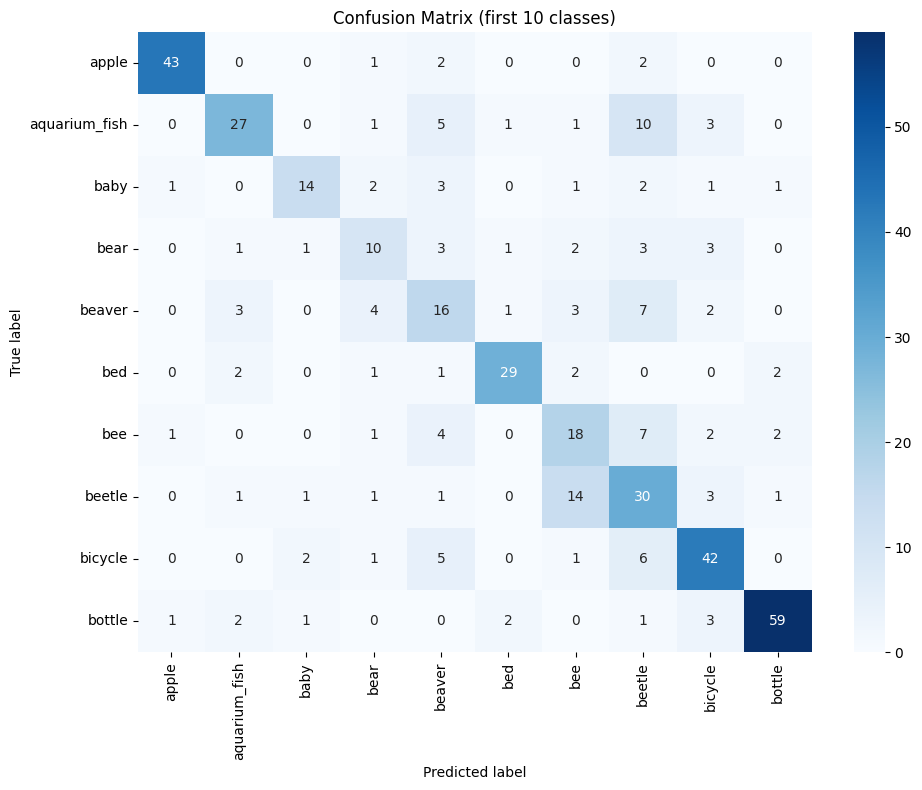

In [12]:
conf_mat = confusion_matrix(y_test, ensemble_preds)
print(f"Confusion matrix shape: {conf_mat.shape}")

# Plot confusion matrix for first 10 classes as an example
fig, ax = plt.subplots(figsize=(10,8))
subset_labels = fine_label_names[:10]  # first 10 class names
sns.heatmap(conf_mat[:10, :10], annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=subset_labels, yticklabels=subset_labels)
plt.title("Confusion Matrix (first 10 classes)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


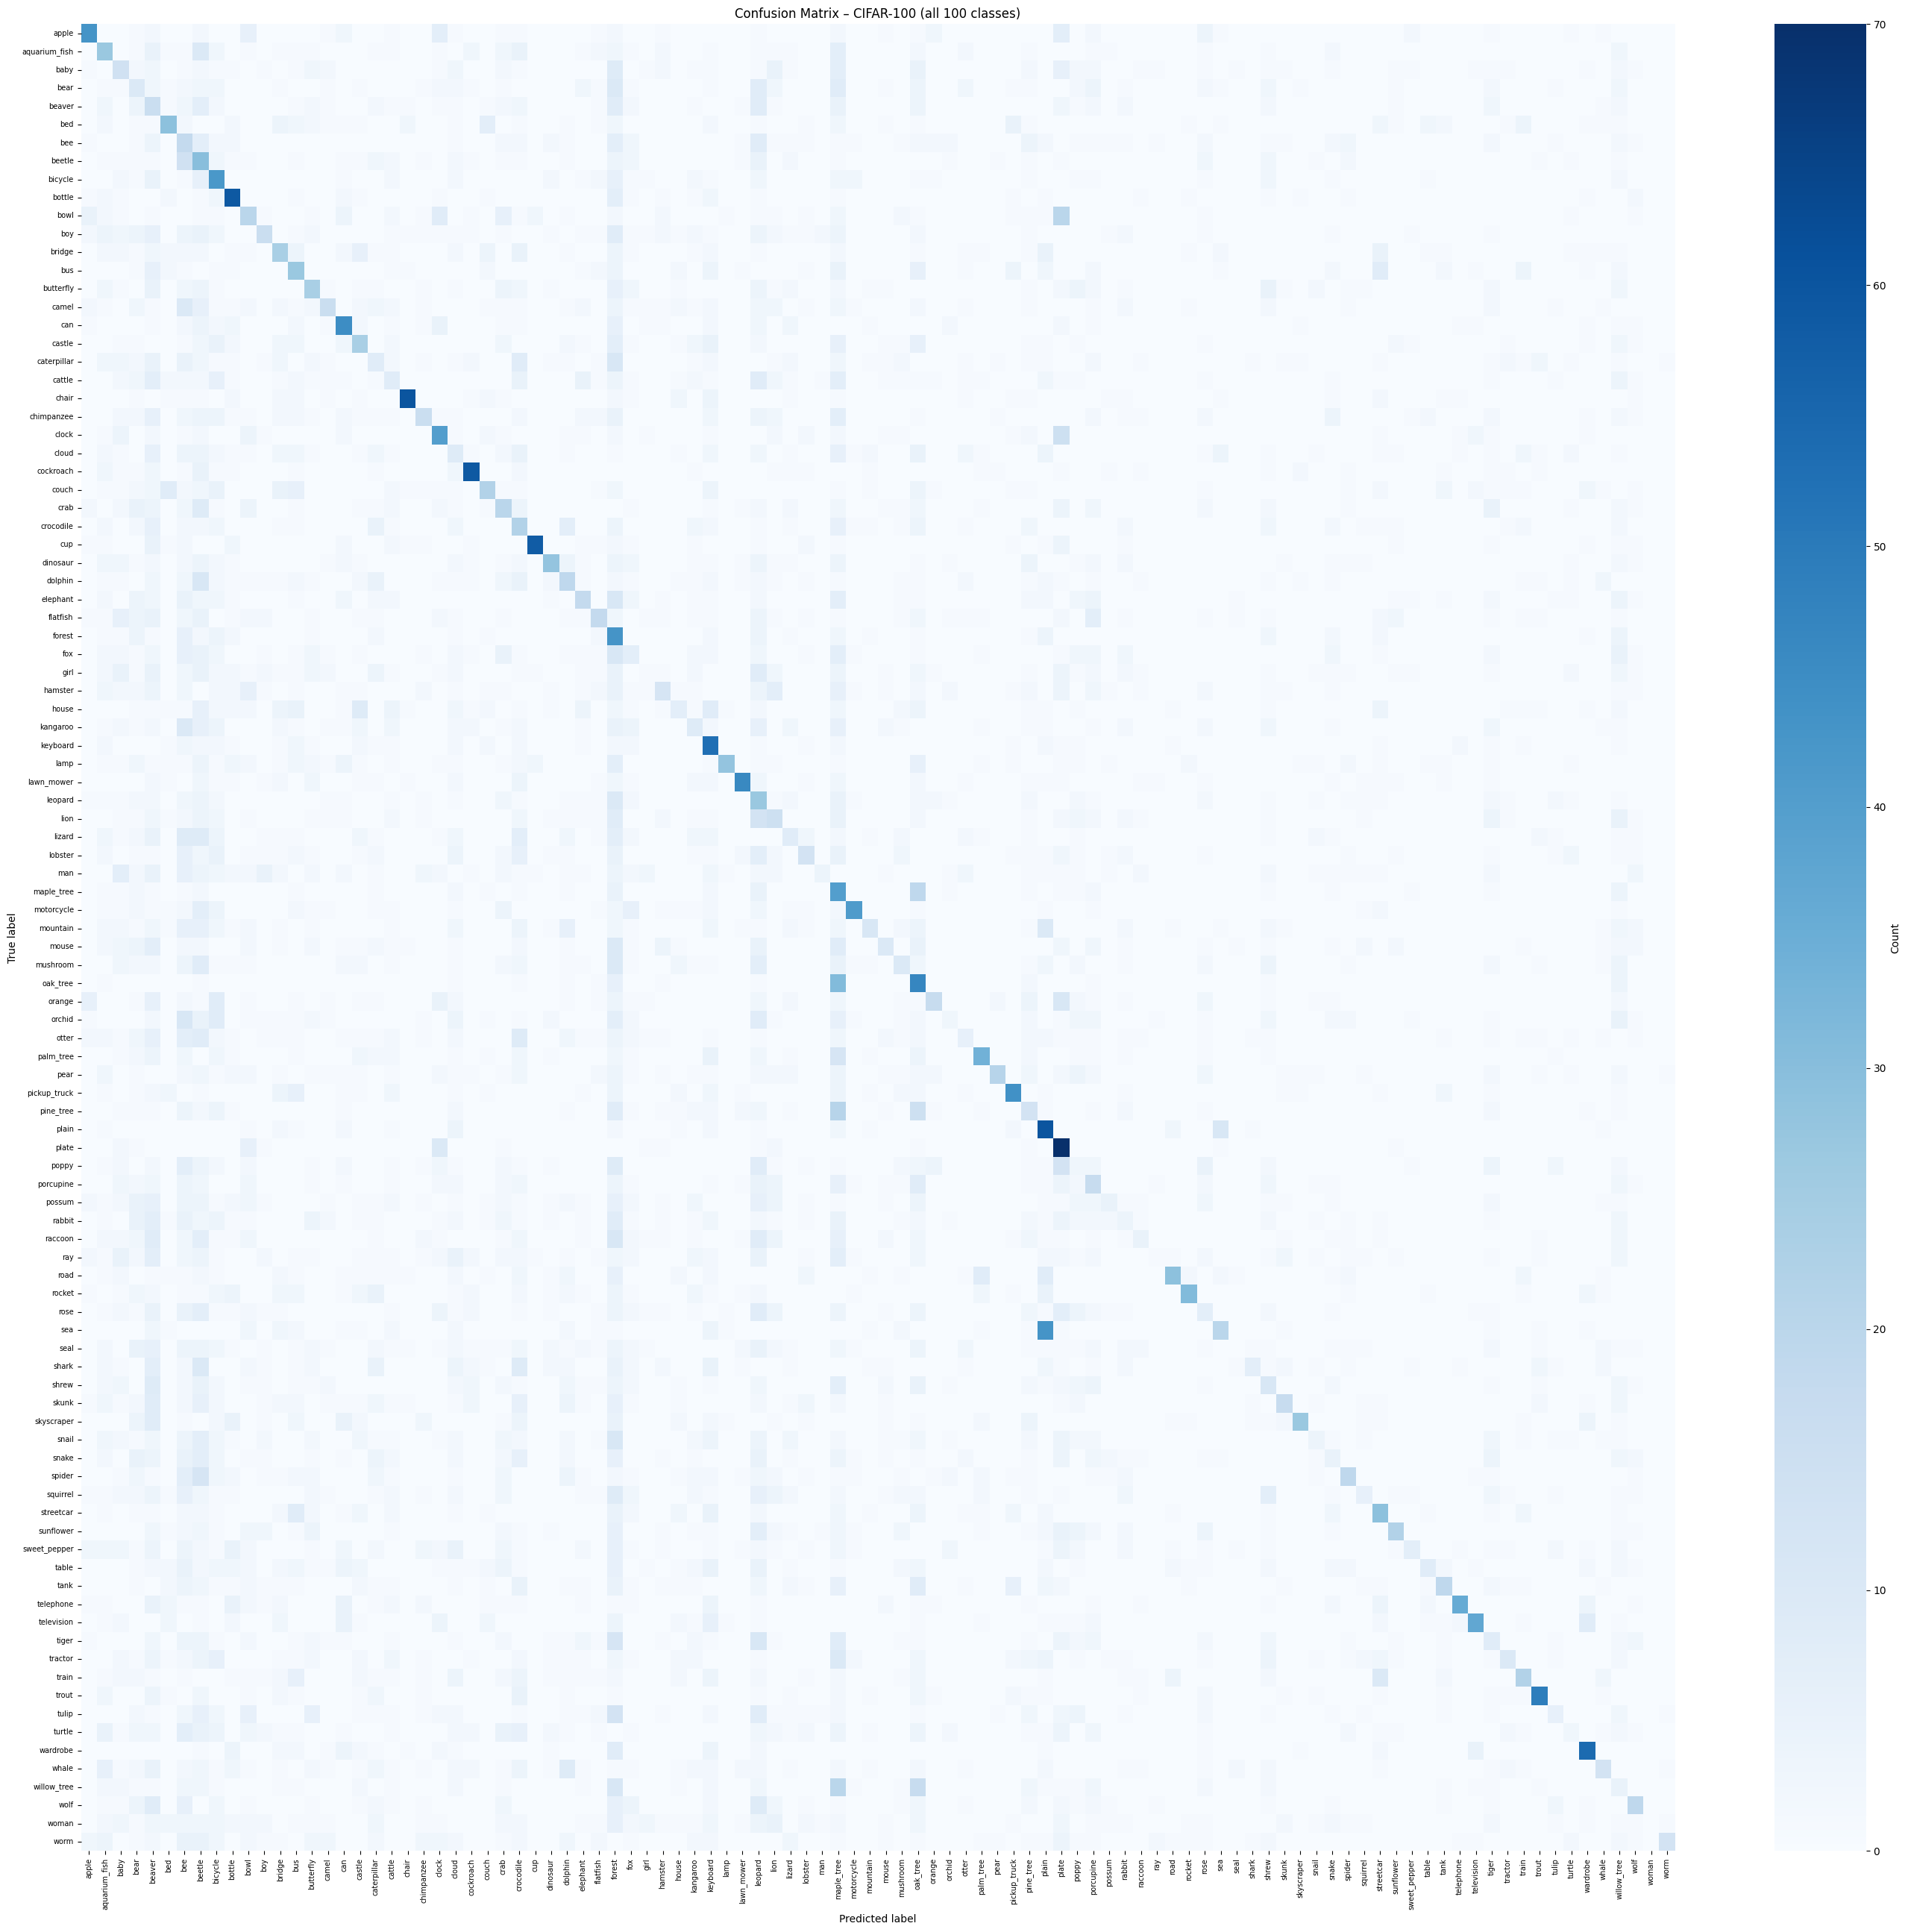

In [13]:
# ── FULL 100×100 CONFUSION MATRIX WITH ALL CLASS NAMES ──────────────────────
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, ensemble_preds)

plt.figure(figsize=(28,26))  # enlarge canvas so all names fit
sns.heatmap(
    conf_mat,
    cmap='Blues',
    annot=False,              # set True if you *also* want raw counts in each cell
    xticklabels=fine_label_names,
    yticklabels=fine_label_names,
    cbar_kws={'label': 'Count'}
)

# Rotate x-axis labels for readability
plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0,  fontsize=7)

plt.title("Confusion Matrix – CIFAR-100 (all 100 classes)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


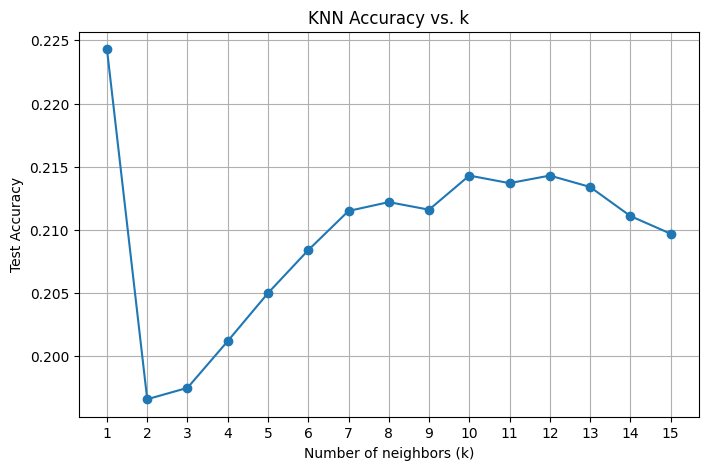

In [14]:
# Evaluate accuracy for different k values (single KNN)
k_values = range(1, 16)
accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_scaled, y_train)
    acc = knn.score(X_test_scaled, y_test)
    accuracies.append(acc)

# Plot accuracy vs k
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o')
plt.title("KNN Accuracy vs. k")
plt.xlabel("Number of neighbors (k)")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.show()


C:\Users\harri\AppData\Local\Temp\ipykernel_8700\1578144854.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=model_accs, palette="viridis")


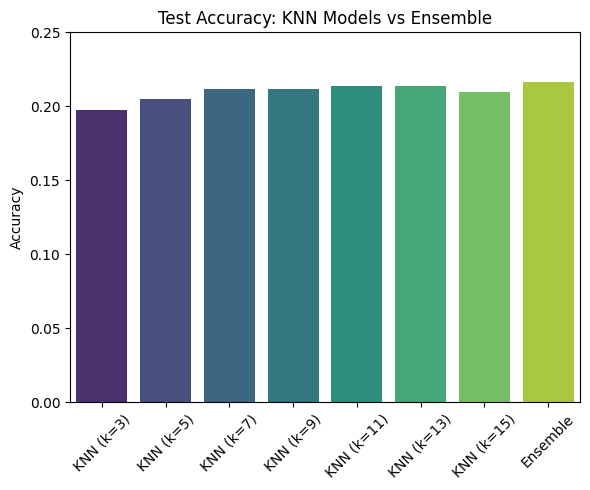

In [15]:
# Bar chart of accuracies
model_names = [f"KNN (k={k})" for k in ks] + ["Ensemble"]
model_accs = [test_accuracy[f'knn_{k}'] for k in ks] + [ensemble_acc]

plt.figure(figsize=(6,5))
sns.barplot(x=model_names, y=model_accs, palette="viridis")
plt.title("Test Accuracy: KNN Models vs Ensemble")
plt.ylim(0, 0.25)
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
